Dataset ucitano: (398, 7)
Ocisceno podataka, preostalo: (396, 7)

Osnovna statistika:
              mpg  horsepower       weight   cylinders
count  396.000000  396.000000   396.000000  396.000000
mean    23.517172  104.189394  2973.000000    5.457071
std      7.834368   38.402030   847.690354    1.703511
min      9.000000   46.000000  1613.000000    3.000000
25%     17.375000   75.000000  2225.250000    4.000000
50%     23.000000   92.000000  2803.500000    4.000000
75%     29.000000  125.000000  3610.000000    8.000000
max     46.600000  230.000000  5140.000000    8.000000

=== KORELACIJA ZNAČAJKI ===
Korelacijska matrica:
            horsepower    weight  cylinders       mpg
horsepower    1.000000  0.864350   0.843751 -0.777575
weight        0.864350  1.000000   0.896058 -0.832725
cylinders     0.843751  0.896058   1.000000 -0.775680
mpg          -0.777575 -0.832725  -0.775680  1.000000

Korelacija s MPG (ciljnom varijablom):
cylinders    : -0.776
              (JAKA negativna korela

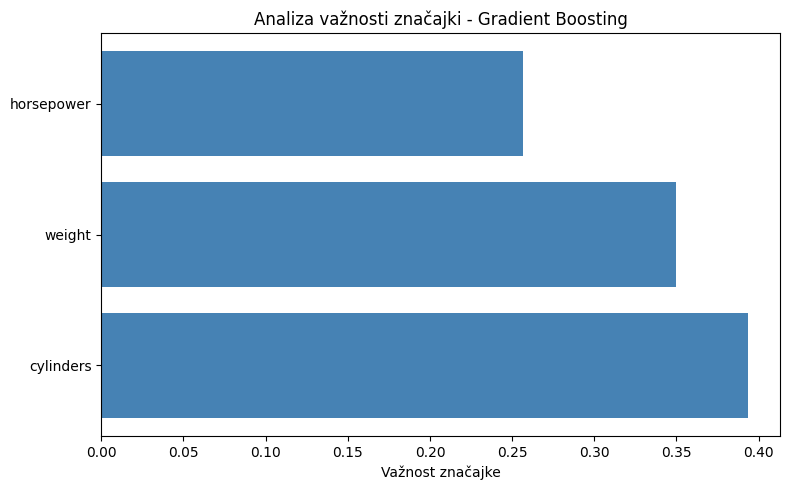


VIZUALIZACIJA PODATAKA


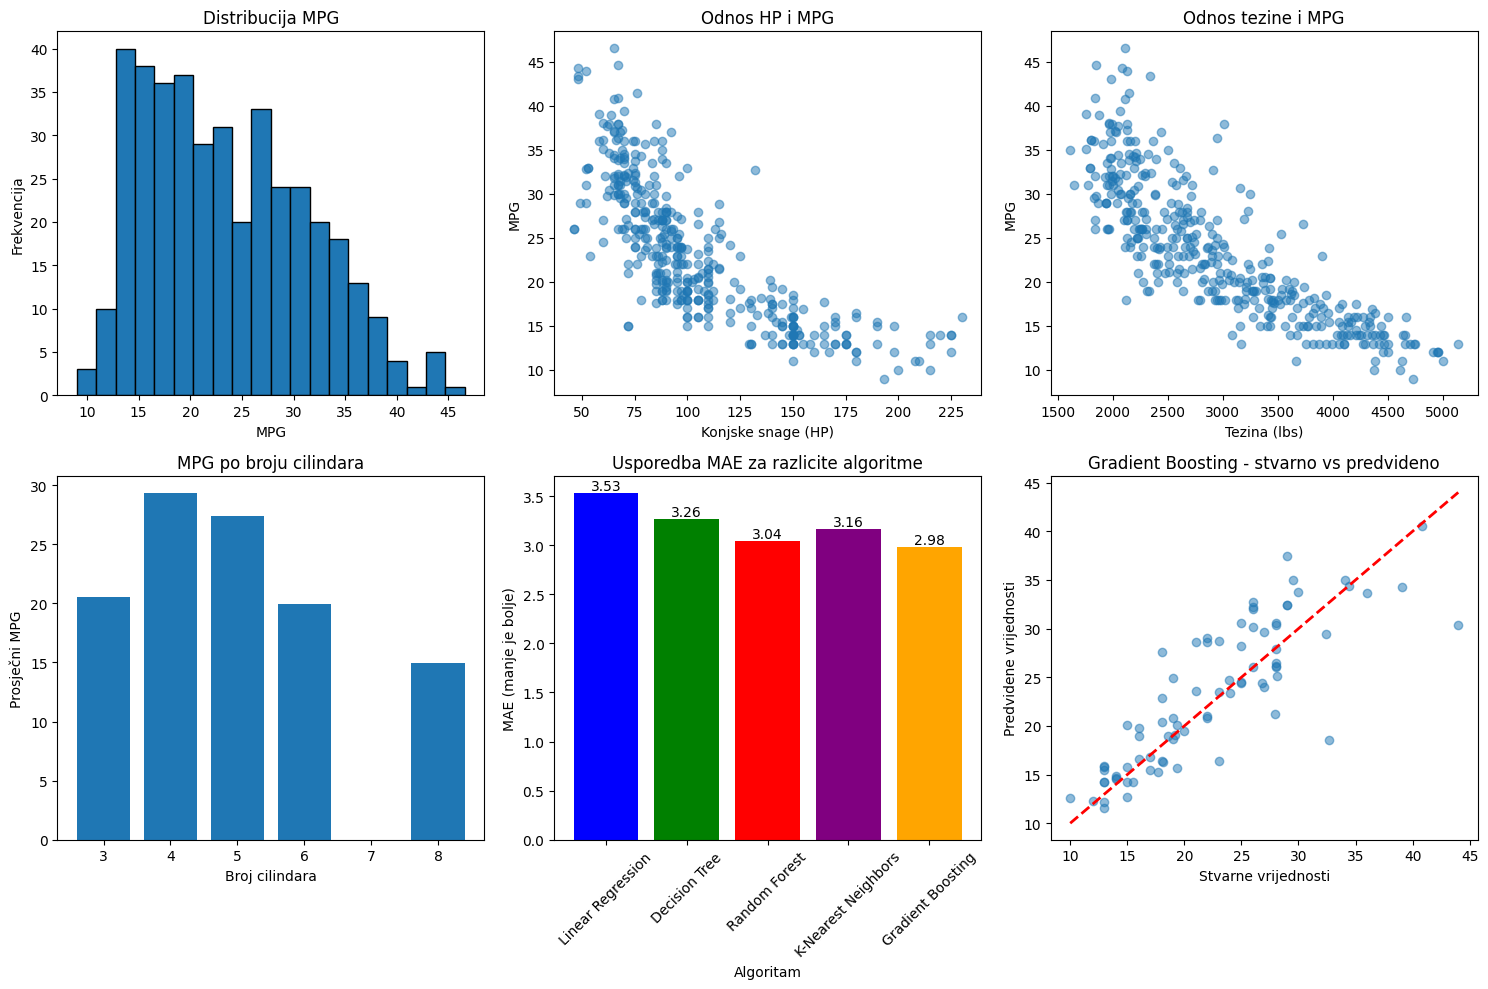


TESTIRANJE API-JA

Cekam da se Flask server pokrene...

Rezultati predvidanja za razlicite tipove vozila:
Ekonomični auto: Nije moguce spojiti se na server. Pokrenite app.py u drugom terminalu.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr

df = pd.read_csv('/content/sample_data/auto-mpg.csv')
print("Dataset ucitano:", df.shape)

df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df = df.dropna()
print("Ocisceno podataka, preostalo:", df.shape)

print("\nOsnovna statistika:")
print(df[['mpg', 'horsepower', 'weight', 'cylinders']].describe())
print("\n=== KORELACIJA ZNAČAJKI ===")

correlation_matrix = df[['horsepower', 'weight', 'cylinders', 'mpg']].corr()
print("Korelacijska matrica:")
print(correlation_matrix)

print("\nKorelacija s MPG (ciljnom varijablom):")
mpg_correlations = correlation_matrix['mpg'].sort_values(ascending=False)
for feature, corr in mpg_correlations.items():
    if feature != 'mpg':
        print(f"{feature:12} : {corr:+.3f}")

        if abs(corr) >= 0.7:
            strength = "JAKA"
        elif abs(corr) >= 0.4:
            strength = "UMJERENA"
        else:
            strength = "SLABA"

        direction = "negativna" if corr < 0 else "pozitivna"
        print(f"              ({strength} {direction} korelacija)")

print("\n--- TOP 3 KORELACIJE S MPG ---")
top_3 = mpg_correlations.drop('mpg').abs().nlargest(3)
for feature in top_3.index:
    corr_value = correlation_matrix.loc[feature, 'mpg']
    print(f"{feature:12} : {corr_value:+.3f}")

print("\nINFERENCIJALNA STATISTIKA (Pearson korelacija + p-value)")

features_for_test = ['horsepower', 'weight', 'cylinders']

for feature in features_for_test:
    corr, p_value = pearsonr(df[feature], df['mpg'])
    print(f"{feature:12} -> korelacija = {corr:+.3f}, p-value = {p_value:.4e}")

    if p_value < 0.05:
        print("              Statistički značajna povezanost (odbacuje se H0)")
    else:
        print("              Nema statistički značajne povezanosti")

features = ['horsepower', 'weight', 'cylinders']
X = df[features]
y = df['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrening set:", X_train.shape, "Test set:", X_test.shape)

print("\nTESTIRANJE 5 ALGORITAMA")


algorithms = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(max_depth=5, random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=5)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42))
]

print("\nCROSS-VALIDATION ANALIZA")
from sklearn.model_selection import cross_val_score

cv_results = []
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5,
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1)
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    cv_results.append({
        'Algorithm': name,
        'CV_MAE': round(cv_mae, 3),
        'CV_STD': round(cv_std, 3)
    })
    print(f"{name}: CV MAE = {cv_mae:.2f} (±{cv_std:.2f})")

print("\nCross-validation potvrđuje stabilnost modela na različitim podjelama podataka")

results = []
for name, model in algorithms:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Algorithm': name,
        'MAE': round(mae, 3),
        'R2': round(r2, 3),
        'Model': model
    })
    print(f"{name}: MAE={mae:.2f}, R2={r2:.3f}")
print("\nUSPOREDBA ALGORITAMA")
for r in results:
    print(f"{r['Algorithm']:<20} MAE: {r['MAE']:<6} R2: {r['R2']}")
best_model = min(results, key=lambda x: x['MAE'])
print(f"\nNajbolji model: {best_model['Algorithm']} (MAE: {best_model['MAE']})")

os.makedirs('models', exist_ok=True)
joblib.dump(best_model['Model'], 'models/best_auto_mpg_model.pkl')
print("Najbolji model spremljen u models/best_auto_mpg_model.pkl")

print("\nANALIZA VAŽNOSTI ZNAČAJKI")

if hasattr(best_model['Model'], 'feature_importances_'):
    importances = best_model['Model'].feature_importances_
    feature_names = features

    indices = np.argsort(importances)[::-1]

    print("Važnost značajki (od najvažnije):")
    for i, idx in enumerate(indices):
        print(f"{i+1}. {feature_names[idx]:12} : {importances[idx]:.3f} ({importances[idx]*100:.1f}%)")

    fig_imp, ax_imp = plt.subplots(figsize=(8, 5))
    ax_imp.barh(feature_names, importances, color='steelblue')
    ax_imp.set_xlabel('Važnost značajke')
    ax_imp.set_title(f'Analiza važnosti značajki - {best_model["Algorithm"]}')
    ax_imp.invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\nVIZUALIZACIJA PODATAKA")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].hist(df['mpg'], bins=20, edgecolor='black')
axes[0, 0].set_xlabel('MPG')
axes[0, 0].set_ylabel('Frekvencija')
axes[0, 0].set_title('Distribucija MPG')

axes[0, 1].scatter(df['horsepower'], df['mpg'], alpha=0.5)
axes[0, 1].set_xlabel('Konjske snage (HP)')
axes[0, 1].set_ylabel('MPG')
axes[0, 1].set_title('Odnos HP i MPG')

axes[0, 2].scatter(df['weight'], df['mpg'], alpha=0.5)
axes[0, 2].set_xlabel('Tezina (lbs)')
axes[0, 2].set_ylabel('MPG')
axes[0, 2].set_title('Odnos tezine i MPG')

cylinders_avg = df.groupby('cylinders')['mpg'].mean()
axes[1, 0].bar(cylinders_avg.index, cylinders_avg.values)
axes[1, 0].set_xlabel('Broj cilindara')
axes[1, 0].set_ylabel('Prosječni MPG')
axes[1, 0].set_title('MPG po broju cilindara')

mae_values = [r['MAE'] for r in results]
algorithm_names = [r['Algorithm'] for r in results]
colors = ['blue', 'green', 'red', 'purple', 'orange']
bars = axes[1, 1].bar(algorithm_names, mae_values, color=colors)
axes[1, 1].set_xlabel('Algoritam')
axes[1, 1].set_ylabel('MAE (manje je bolje)')
axes[1, 1].set_title('Usporedba MAE za razlicite algoritme')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].bar_label(bars, fmt='%.2f')

actual_vs_pred = results[algorithm_names.index(best_model['Algorithm'])]
model_for_plot = actual_vs_pred['Model']
y_pred_best = model_for_plot.predict(X_test)

axes[1, 2].scatter(y_test, y_pred_best, alpha=0.5)
axes[1, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 2].set_xlabel('Stvarne vrijednosti')
axes[1, 2].set_ylabel('Predvidene vrijednosti')
axes[1, 2].set_title(f'{best_model["Algorithm"]} - stvarno vs predvideno')

plt.tight_layout()
plt.show()